In [1132]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, return_plot, plot_important_features
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Read in Data

In [1133]:
%store -r correlative_factors
%store -r outlier_cols
correlative_factors.pop('saleprice', None)

# training data
house_train = pd.read_csv('../datasets/house_train_improved.csv')
# testing data
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# increase column width
pd.set_option('display.max_columns', 300)

In [1134]:
house_train = house_train.query('gr_liv_area < 4000')

In [1135]:
house_train.shape

(2049, 139)

In [1136]:
drop = []

### Polytransformation

In [1137]:
poly_columns = ['gr_liv_area', 'overall_qual_cond']   
def poly_features(df):
    for x in poly_columns:
        df[x+'_poly'] = df[x]**2
poly_features(house_train)
poly_features(house_test)

In [1138]:
# add '_poly to poly_columns
poly_columns = [x+'_poly' for x in poly_columns]


### Log and Sqrt Transformations of Skewed Features

In [1139]:
### Feature Transformation

sqrt_vars = ['total_bsmt_sf', 'house_age']
for col in sqrt_vars:
    house_train[col] = np.sqrt(house_train[col])
    house_test[col] = np.sqrt(house_test[col])

log_vars = ['lot_area', 'lot_frontage', 'gr_liv_area']
for col in log_vars:
    house_train[col] = np.log(house_train[col])
    house_test[col] = np.log(house_test[col])
    

In [1140]:
log_vars

['lot_area', 'lot_frontage', 'gr_liv_area']

### Log Sale Price

In [1141]:
house_train.saleprice = np.log(house_train.saleprice)
log_flag = True

In [1142]:
correlative_factors = {k:v for k,v in correlative_factors.items() if v not in drop}

In [1143]:
FEATURES = correlative_factors.keys()
FEATURES = [x for x in correlative_factors.keys() if x not in drop]
FEATURES+= poly_columns + outlier_cols

In [1144]:

X = house_train[FEATURES]
y = house_train.saleprice
X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

### Instantiate LassoCV Model

In [1145]:

mlr_lasso = LassoCV(alphas = np.arange(0.001, 10, 1))
#calculate residuals by creating predictions
mlr_lasso.fit(Xs_train,y_train)
preds = mlr_lasso.predict(Xs_train)
resid = y_train - preds

### Scores

In [1146]:
def get_scores(model, standardize=True, log_price=False):
    
    if standardize == True:
        X_train_ = Xs_train
        X_val_ = Xs_val
    else:
        X_train_ = X_train
        X_val_ = X_val

    if log_price == True:
        var_preds = np.exp(preds)
        var_y_train = np.exp(y_train)
    else:
        var_preds = preds
        var_y_train = y_train

    scores_1 = (cross_val_score(model, X_train_, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=42)))
    print('Training R^2 Score: ', model.score(X_train_, y_train))
    print('Training RMSE: ', mean_squared_error(var_preds, var_y_train, squared = False))
    print('Cross Validation R^2 Score: ', scores_1.mean())
    print('Validation R^2 Score', model.score(X_val_, y_val))

get_scores(mlr_lasso, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9196128197826738
Training RMSE:  20841.403509590586
Cross Validation R^2 Score:  0.912994452598865
Validation R^2 Score 0.8710163155206796


### Plots

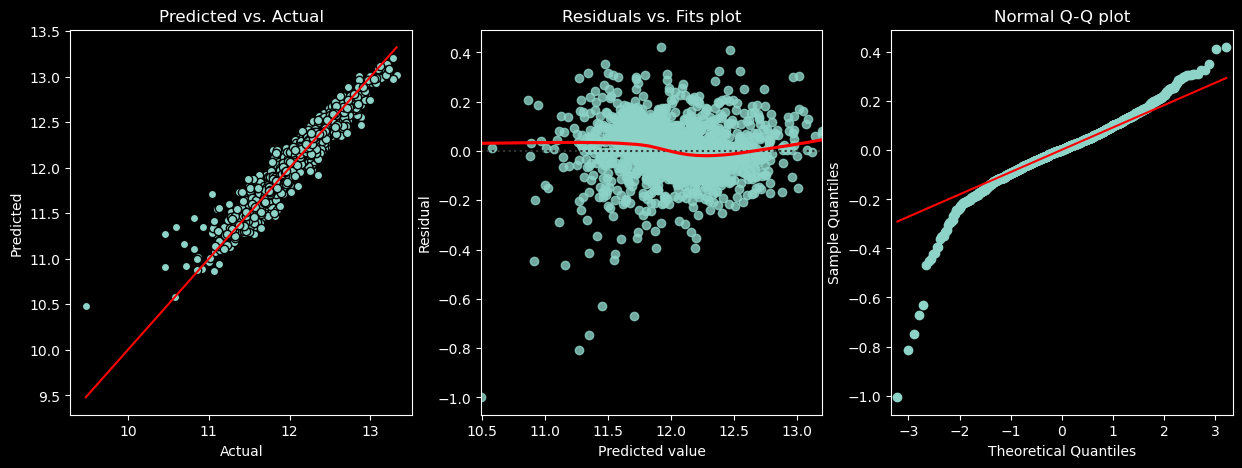

In [1147]:
return_plot(preds, y_train, resid)

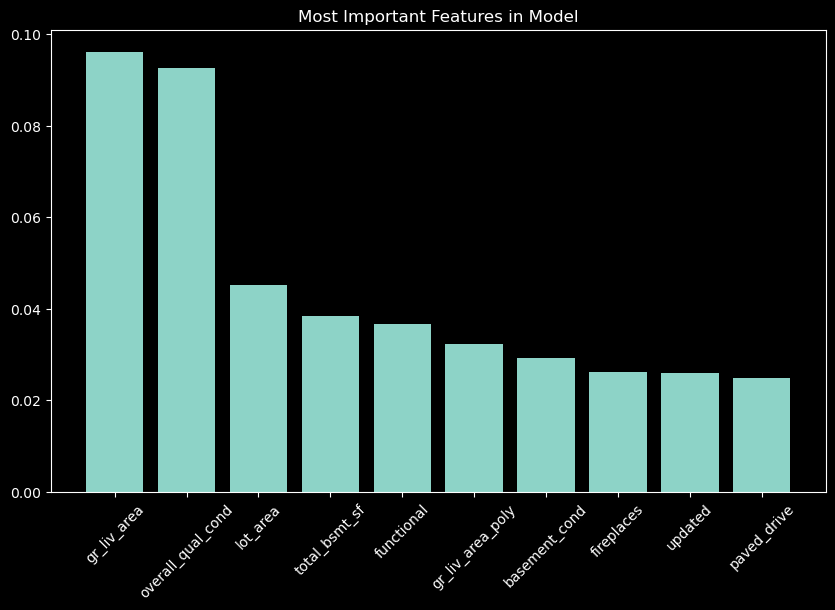

In [1148]:
plot_important_features(mlr_lasso, Xs_train, n_features=10)

### Columns Lasso is Minimizing

In [1149]:
squashed_columns = []
for idx, item in enumerate(mlr_lasso.coef_):
    if item == 0:
        squashed_columns.append(idx)
    
squashed_columns
Xs_train.iloc[:,squashed_columns].columns

Index(['totrms_abvgrd', 'fence', 'has_fireplace', 'Feedr', 'PConc', 'Slab',
       '2fmCon', 'Duplex', 'Twnhs', 'overall_qual_cond_poly'],
      dtype='object')

### Instantiate Ridge Model

In [1150]:
mlr_ridge = Ridge()
#calculate residuals by creating predictions
mlr_ridge.fit(Xs_train,y_train)
preds = mlr_ridge.predict(Xs_train)
resid = y_train - preds

### Scores

In [1151]:
get_scores(mlr_ridge, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9199435596400435
Training RMSE:  20684.18067722441
Cross Validation R^2 Score:  0.9120650043309672
Validation R^2 Score 0.8702643534065221


### Plots

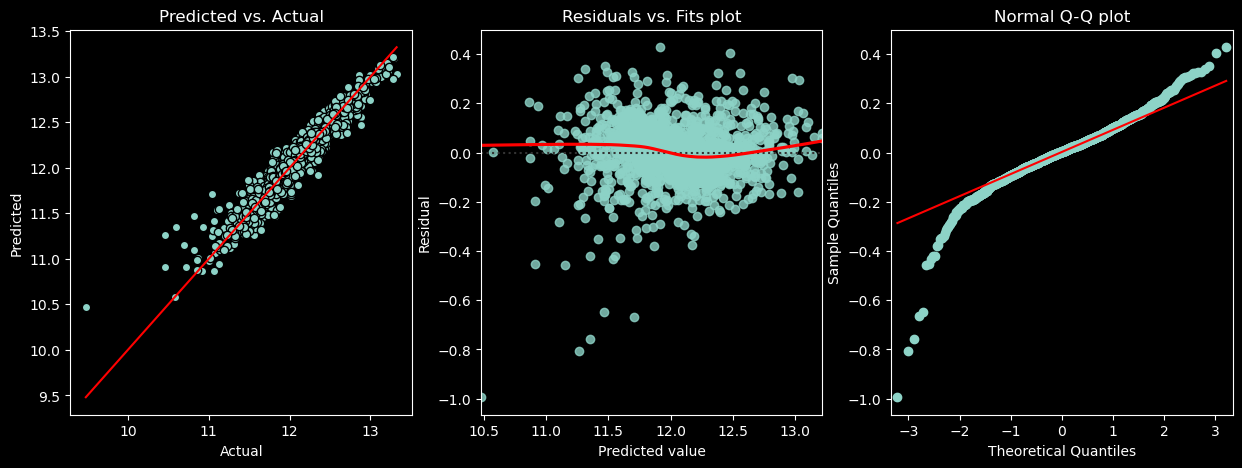

In [1152]:
return_plot(preds, y_train, resid)

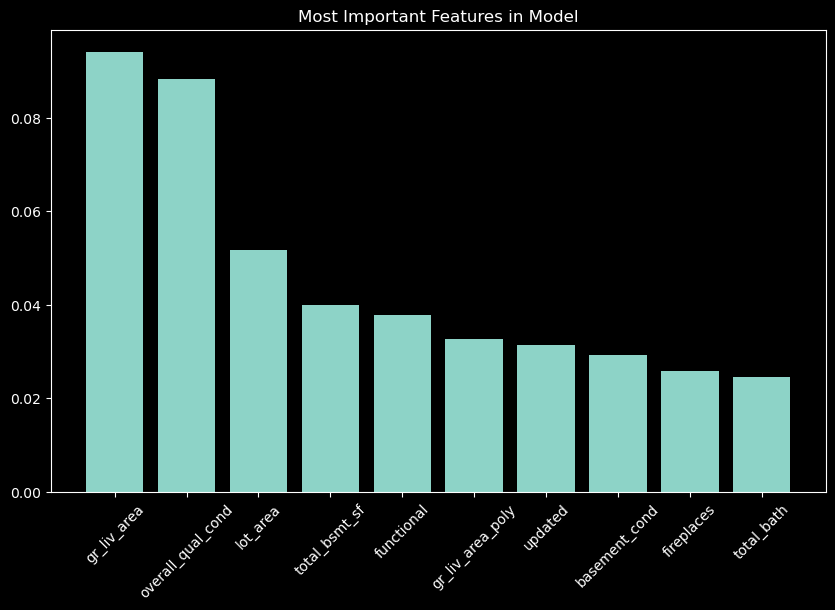

In [1153]:
plot_important_features(mlr_ridge, X_train, n_features=10)

### Instantiate OLS Model

In [1154]:
mlr_ols = LinearRegression()
#calculate residuals by creating predictions
mlr_ols.fit(Xs_train,y_train)
preds = mlr_ols.predict(Xs_train)
resid = y_train - preds

### Scores

In [1155]:
get_scores(mlr_ols, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9199449847920488
Training RMSE:  20700.85657024099
Cross Validation R^2 Score:  0.9120307098209223
Validation R^2 Score 0.8703167275276397


### Plots

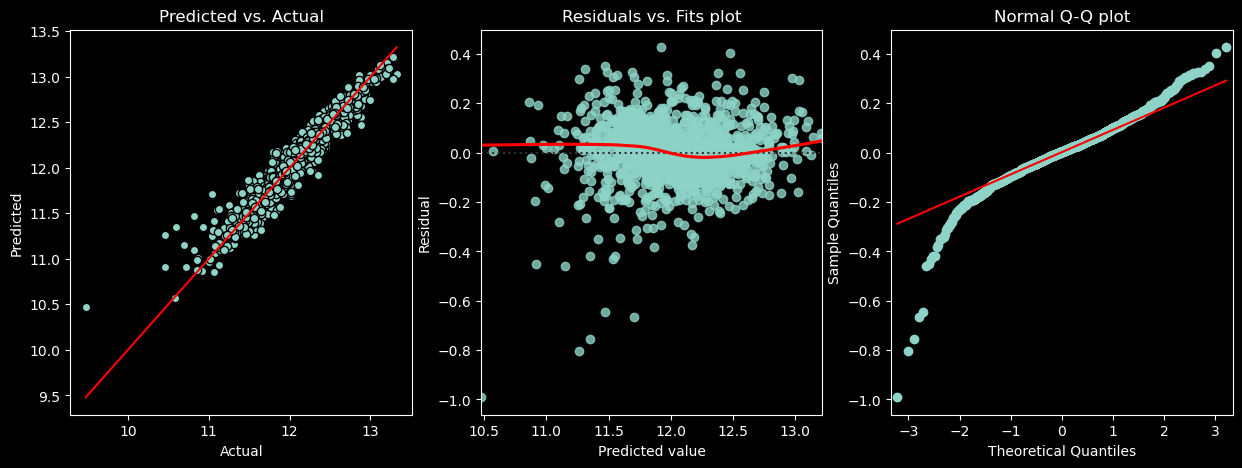

In [1156]:
return_plot(preds, y_train, resid)

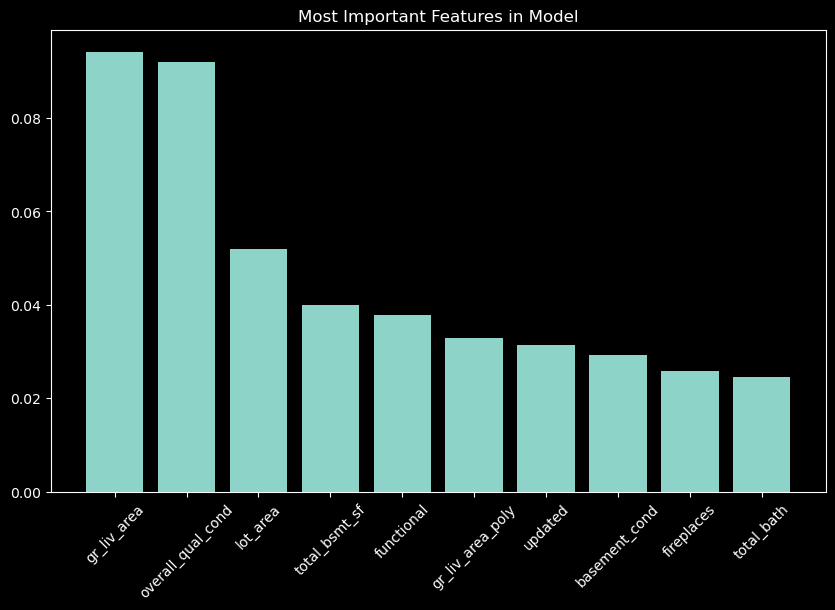

In [1157]:
plot_important_features(mlr_ols, X_train, n_features=10)

# Linear Assumptions

Variance Inflation Factor

In [1158]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(Xs_train.values, i) for i in range(Xs_train.shape[1])]
vif["features"] = Xs_train.columns;

vif.query('VIF_Factor > 5')

c:\Users\alexs\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF_Factor,features
3,6.646237,fireplaces
4,6.462229,garage_cars
6,7.669761,lot_area
9,12.848025,gr_liv_area
10,6.083026,garage_area
19,6.493463,has_fireplace
29,78.747261,overall_qual_cond
38,11.652320,house_age
42,7.059265,gr_liv_area_poly
43,76.886100,overall_qual_cond_poly


Statsmodels

In [1159]:
X_sm = sm.add_constant(X_train)

res = sm.OLS(y_train, X_sm).fit()
preds = res.predict(sm.add_constant(X_test))
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     380.5
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:03:01   Log-Likelihood:                 1129.1
No. Observations:                1536   AIC:                            -2166.
Df Residuals:                    1490   BIC:                            -1921.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       7.6633      0.217     35.302      0.000       7.238       8.089
bedroom_abvgr              -0.0099      0.006     -1.707      0.088      -0.021       0.001
kitchen_abvgr              -0.0747      0.027     -2.793      0.005      -0.127      -0.022
totrms_abvgrd               0.0017      0.004      0.413      0.679      -0.007       0.010
fireplaces                  0.0406      0.012      3.340      0.001       0.017       0.065
garage_cars                 0.0090      0.010      0.895      0.371      -0.011       0.029
lot_frontage                0.0028      0.015      0.182      0.856      -0.027       0.033
lot_area                    0.1028      0.016      6.241      0.000       0.070       0.135
mas_vnr_area             5.919e-05   2.07e-05      2.857      0.004    1.85e-05    9.98e-05
total_bsmt_sf               0.0051      0.001      6.711      0.000       0.004       0.007
gr_liv_area                 0.2974      0.034      8.743      0.000       0.231       0.364
garage_area              6.176e-05   3.46e-05      1.785      0.074    -6.1e-06       0.000
wood_deck_sf              9.16e-05   2.62e-05      3.493      0.000    4.02e-05       0.000
heating_qc                  0.0162      0.004      3.826      0.000       0.008       0.025
kitchen_qual                0.0312      0.007      4.245      0.000       0.017       0.046
functional                  0.0523      0.004     11.676      0.000       0.043       0.061
paved_drive                 0.0822      0.013      6.412      0.000       0.057       0.107
fence                    7.798e-06      0.008      0.001      0.999      -0.016       0.016
alley                      -0.0230      0.013     -1.720      0.086      -0.049       0.003
central_air                 0.0756      0.015      5.184      0.000       0.047       0.104
has_fireplace              -0.0009      0.015     -0.061      0.952      -0.031       0.029
Feedr                       0.0119      0.018      0.667      0.505      -0.023       0.047
Norm                        0.0591      0.012      4.888      0.000       0.035       0.083
PosN                        0.0766      0.029      2.670      0.008       0.020       0.133
CBlock                     -0.0132      0.088     -0.149      0.881      -0.187       0.160
PConc                      -0.0056      0.011     -0.529      0.597      -0.026       0.015
Slab                        0.0149      0.034      0.445      0.656      -0.051       0.081
2fmCon                      0.0027      0.022      0.124      0.902      -0.041       0.046
Duplex                      0.0136      0.029      0.472      0.637      -0.043       0.070
Twnhs                       0.0068      0.022      0.306      0.760      -0.037       0.050
overall_qual_cond           0.0977      0.028  

# Submission

In [1160]:
#E instantiate lasso with best alpha 

new_lasso = Lasso(alpha = 0.001)
new_lasso.fit(X,y)

ss = StandardScaler()
Xs_test = ss.fit_transform(X_test)
Xs_test = pd.DataFrame(Xs_test, columns = ss.get_feature_names_out())



price_preds = new_lasso.predict(X_test)
house_test['SalePrice'] = np.exp(price_preds)

house_test
house_test[['id', 'SalePrice']].to_csv('../datasets/submission.csv', index = False)

In [1161]:
house_test[['id', 'SalePrice']]


,id,SalePrice
0,2658,116710.726986
1,2718,162486.181150
2,2414,229728.783069
3,1989,114063.194307
4,625,175056.573099
...,...,...
873,1662,180629.005888
874,1234,219672.561414
875,1373,130752.822912
876,1672,112360.261884


In [1162]:
current_df = house_test[['id', 'SalePrice']]
best_df = pd.read_csv('../datasets/best_submission.csv')
best_df = best_df.join(current_df.set_index('id'), on='id', lsuffix='_best', rsuffix='_current')
best_df['diff'] = best_df['SalePrice_best'] - best_df['SalePrice_current']
best_df.sort_values('diff', ascending=False)

,id,SalePrice_best,SalePrice_current,diff
387,1529,207420.8857,197165.450440,10255.435260
317,1001,243385.1996,233900.670127,9484.529473
856,352,223936.5858,215028.045262,8908.540538
344,93,303969.9466,295522.616764,8447.329836
770,1769,259499.1806,251437.001520,8062.179080
...,...,...,...,...
756,1696,433654.7852,466463.530366,-32808.745166
237,422,428924.9225,465948.416284,-37023.493784
115,2446,511529.0098,585640.521107,-74111.511307
170,1761,564067.5912,689633.909437,-125566.318237


In [1163]:
ids = [1761, 2216, 1768]

In [1164]:
house_test.query('id in @ids')

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_cond,foundation,bsmt_exposure,total_bsmt_sf,heating,heating_qc,central_air,electrical,gr_liv_area,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,garage_type,garage_finish,garage_cars,garage_area,paved_drive,wood_deck_sf,pool_area,fence,misc_val,mo_sold,sale_type,has_fireplace,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,Greens,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,2fmCon,Duplex,Twnhs,TwnhsE,AsphShn,BrkComm,BrkFace,CemntBd,HdBoard,MetalSd,Plywood,Stucco,VinylSd,Wd Sdng,WdShing,CBlock,PConc,Slab,Stone,Wood,Tar&Grv,WdShake,WdShngl,NoSewr,Feedr.1,Norm.1,PosA.1,PosN.1,RRAe.1,RRAn.1,RRNe.1,RRNn.1,overall_qual_cond,basement_cond,2nd_story,total_bath,total_porch_sf,neighborhood_price_rank,updated,garage_age,garage_qual_cond,house_age,land_house_ratio,has_pool,meltdown,lot_frontage_outliers,lot_area_outliers,mas_vnr_area_outliers,total_bsmt_sf_outliers,gr_liv_area_outliers,garage_area_outliers,gr_liv_area_poly,overall_qual_cond_poly,SalePrice
170,1761,528320050,60,RL,5.075174,9.656499,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,5,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,2,PConc,NaN,48.948953,GasA,4,1,SBrkr,8.406485,4,1,4,10,3,2,Attchd,Fin,3,813,1,171,555,1,0,7,WD,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.5,3.0,1,4.5,78,2,0,11.0,2.0,3.316625,3.490393,1,0,1,1,1,1,1,1,20034576,42.25,689633.909437
463,1768,528351010,60,RL,4.644391,9.977435,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,6,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,2,PConc,3.0,49.436828,GasA,4,1,SBrkr,8.370084,4,1,4,10,3,2,Attchd,Fin,3,832,1,382,0,0,0,1,WD,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,7.0,3.0,1,4.0,50,2,1,13.0,2.0,3.605551,4.989574,0,0,0,0,0,0,0,0,18627856,49.00,758541.205795


<AxesSubplot:xlabel='SalePrice_best', ylabel='id'>

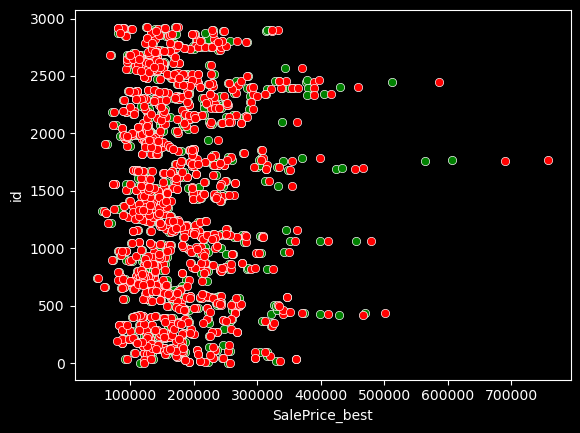

In [1165]:
sns.scatterplot(best_df, x = 'SalePrice_best', y = 'id', color = 'green')
sns.scatterplot(best_df, x = 'SalePrice_current', y = 'id', color = 'red')
